In [1]:
using DifferentialEquations, Random, LinearAlgebra, MKL, TensorOperations, DelimitedFiles, Plots

In [3]:

@views function doubleExcitation_memoryTuned(du, u, p, t)
    N, G, Ωₗ, Γₗ, Δₗ, dβₖₗ = p
    βₗ = u[1:N]
    βₖₗ = reshape(u[N+1:end], N, N)

    for l = 1:N
        du[l] = (im * Δₗ[l] - Γₗ[l] / 2) * βₗ[l] - 0.5 * im * Ωₗ[l]  # v2
    end
    mul!(du[1:N], -G, βₗ) # du[1:N] .= - G*βₗ


    for k = 1:N
        Ωₖ = Ωₗ[k]
        Gₖ = G[k, :]
        βₖ_linha = βₖₗ[k, :]
        βₖ = βₗ[k]
        for l = 1:N
            dβₖₗ[k, l] =
                (im * (Δₗ[k] + Δₗ[l]) - 0.5 * (Γₗ[k] + Γₗ[l])) * βₖₗ[k, l] -
                0.5im * (Ωₗ[l] * βₖ + Ωₗ[k] * βₗ[l]) - dot(G[l, :], βₖ_linha) -
                dot(Gₖ, βₖₗ[:, l])
        end
    end
    du[N+1:end] .= dβₖₗ[:]

    return nothing
end








doubleExcitation_speedTuned (generic function with 1 method)

4

In [26]:
A = [1 2 3 4;1 2 3 4;1 2 3 4; 1 2 3 4] 
length(A)

16

In [91]:
function doubleExcitation_full_speedTuned(du, u, p, t)
      N, G, Ωₗ, Γₗ, Δₗ, rightIndex, _temp = p

      βₗ = u[1:N]
      βₖₗ = reshape(u[N+1:N+N*N], N, N) # check if N*N works instead of end
      γₖₗ = reshape(u[N+N*N+1:end], N, N)

      #βₗcalculations
      for l = 1:N
          du[l] = (im * Δₗ[l] - Γₗ[l] / 2) * βₗ[l] - 0.5 * im * Ωₗ[l]
      end
      mul!(du[1:N], G, βₗ)
  
      #βₖₗcalculations
      @tensor begin
          _temp[k, l] = G[l, m] * βₖₗ[k, m] + G[k, m] * βₖₗ[m, l]
      end
      for k = 1:N
          for l = 1:N        
                if (k == l)
                      du[N+rightIndex[k, l]] = 0
                  else
                      du[N+rightIndex[k, l]] =
                          (im * (Δₗ[k] + Δₗ[l]) - 0.5 * (Γₗ[k] + Γₗ[l])) * βₖₗ[k, l] -
                          0.5im * (Ωₗ[l] * βₗ[k] + Ωₗ[k] * βₗ[l]) + _temp[k, l]
                  end
              end
          end
    
      Gᴴ = adjoint(G)
      #γₖₗ
      @tensor begin
              _temp[k, l] = G[k, m] * γₖₗ[m, l] + Gᴴ[l, m] * γₖₗ[k, m]
      end

      for k = 1:N
          for l = 1:N
              #if (k == l)
              #    du[N*N+rightIndex[k, l]] = 0
              #else
                  du[N*N+rightIndex[k, l]] =
                     (im * (Δₗ[k] - Δₗ[l]) - 0.5 * (Γₗ[k] + Γₗ[l])) * γₖₗ[k, l] -
                     0.5im * (  Ωₗ[k] * adjoint(βₗ[l]) - adjoint(Ωₗ[l]) * βₗ[k])  + _temp[k, l]
             end
         end
     end          
    return nothing
end
            
            

LoadError: syntax: unexpected "end"

In [92]:
function benchmark_test(p)
        N, G, Ωₗ, Γₗ, Δₗ = p
        #G = rand(ComplexF64, N, N);
        G[diagind(G)] .= 0 # avoid the case "m ≠ l"  for dot product
        G .= -G  # avoid an extra operation of negative ("-") inside the TensorOperations

        #Ωₗ = rand(ComplexF64, N)
        #Γₗ = rand(ComplexF64, N)
        #Δₗ = rand(N)
        rightIndex = LinearIndices(G)
        _temp = similar(G)


        p_memory = N, G, Ωₗ, Γₗ, Δₗ, _temp
        p_speed = N, G, Ωₗ, Γₗ, Δₗ, rightIndex, _temp

        u0 = rand(ComplexF64, N + N^2 + N^2 )*0

        prob_speed = ODEProblem(doubleExcitation_full_speedTuned, u0, (0.0, 10.0), p_speed)

        sol_speed   = solve(prob_speed, saveat=0.05)
        sol = sol_speed

        t  = sol.t
        #print(length(t))

        β_full = sol.u
        
        β_full = reduce(hcat,β_full)
        #print(length(βₗ))
        #βₖₗ = [reshape(sol.u[i][N+1:end], N, N) for i in 1:length(sol.u)]


        #printls(p_memory[:length(p_memory)-1])

        
        #writedlm("../time_test.csv", t, ",")
        #writedlm("../beta_full_test.csv", β_full, ",")
        
        return t, β_full, sol
end


#N = 2
#G = ComplexF64[[0.5 0.5]; [0.5 0.5]]
#Γₗ= ComplexF64[1, 1]
#Ωₗ= Float64[0.1, 0.1 ]
#Δₗ= Float64[20,20 ]
#		
#p = N, G, Ωₗ, Γₗ, Δₗ 
#
#benchmark_test(p)
#


benchmark_test (generic function with 1 method)

In [93]:
G = ComplexF64[[1 -0.06+0.8im]; [-0.06 + 0.8im 0.5]]

2×2 Matrix{ComplexF64}:
   1.0+0.0im  -0.06+0.8im
 -0.06+0.8im    0.5+0.0im

In [94]:
N = 2
G = ComplexF64[[1 -0.006+0.8im]; [-0.006 + 0.8im 1]]
Γₗ= ComplexF64[2, 2]
Ωₗ= Float64[-0.08, 0.03 ]
Δₗ= Float64[20.0,20.0 ]

p = N, G, Ωₗ, Γₗ, Δₗ 

(2, ComplexF64[1.0 + 0.0im -0.006 + 0.8im; -0.006 + 0.8im 1.0 + 0.0im], [-0.08, 0.03], ComplexF64[2.0 + 0.0im, 2.0 + 0.0im], [20.0, 20.0])

In [95]:
t, β, sol =  benchmark_test(p)

([0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45  …  9.55, 9.6, 9.65, 9.7, 9.75, 9.8, 9.85, 9.9, 9.95, 10.0], ComplexF64[0.0 + 0.0im -0.0008898293322627727 + 0.0016453553925112612im … -0.0019950612776907027 + 9.96692105277034e-5im -0.0019949723929295073 + 9.966971414711422e-5im; 0.0 + 0.0im 0.00033368599959853964 - 0.0006170082721917228im … 0.000748147979134014 - 3.7375953947888815e-5im 0.0007481146473485656 - 3.737614280516746e-5im; … ; 0.0 + 0.0im 5.865145030656e-312 + 5.865143270587e-312im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 5.86514503066e-312 + 5.865143270503e-312im … 0.0 + 0.0im 0.0 + 0.0im], OrdinaryDiffEq.ODECompositeSolution{ComplexF64, 2, Vector{Vector{ComplexF64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{ComplexF64}}}, ODEProblem{Vector{ComplexF64}, Tuple{Float64, Float64}, true, Tuple{Int64, Matrix{ComplexF64}, Vector{Float64}, Vector{ComplexF64}, Vector{Float64}, LinearIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, Matrix{ComplexF64}}, OD

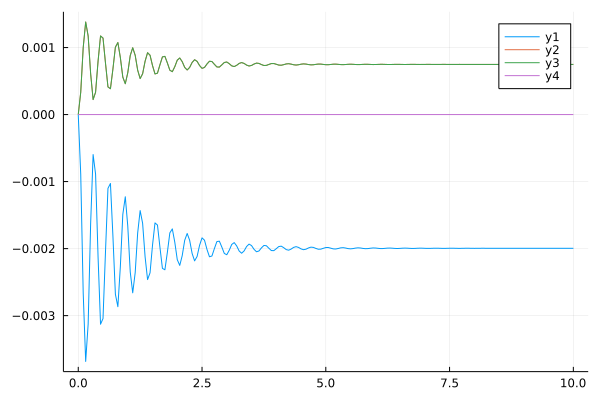

In [97]:
plot(sol.t,  real(β[1,:]))
plot!(sol.t, real(β[2,:]))
plot!(sol.t,  real(β[2,:]))
plot!(sol.t, real(β[3,:]))


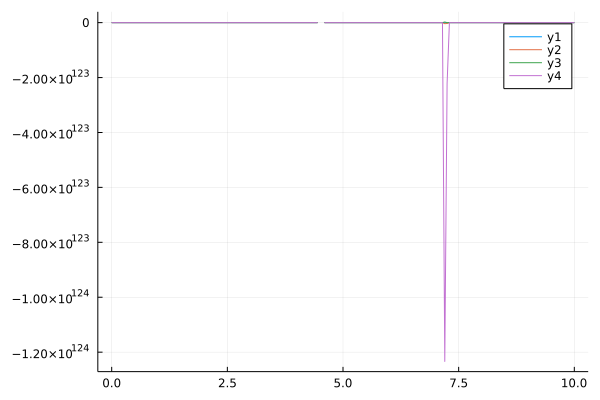

In [98]:
plot(sol.t,  real(β[5,:]))
plot!(sol.t, real(β[6,:]))
plot!(sol.t, real(β[7,:]))
plot!(sol.t, real(β[8,:]))
